In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**Загрузка данных**

In [2]:
url = "fake_job_postings.csv"
chunk_size = 1000
chunk_arr = []
for chunk in pd.read_csv("fake_job_postings.csv", chunksize=chunk_size):
    #print(chunk)
    chunk_arr.append(chunk)
print(len(chunk))
data = pd.concat(chunk_arr, ignore_index=True)

880


Данные загружаются частями и соединяются в конце. Иначе датасет полностью не загружался

Теперь выведем на экран первые 5 объектов:

In [3]:
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
print(data.shape)

(17880, 18)


Датасет включает в себя 17880 объектов с 18 признаками

**Обработка пропущенных значений**

Выведем на экран количество пропущенных значений для каждого признака:

In [5]:
missing_values = data.isnull().sum()
print(missing_values)

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


Удалим признаки, которые невозможно обработать (текстовые поляс описанием) или которые не влияют на результат (job_id) повлияют на результат:

In [6]:
data=data.drop(['job_id','title','location','department','salary_range','company_profile','description','requirements','benefits'],axis=1)

In [7]:
missing_values = data.isnull().sum()
print(missing_values)

telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64


Поскольку по некоторым признакам слишком много пропущенных значений, имеет смысл удалить часть объектов, а для оставшихся заменить пропущенные значения модой

In [8]:
data.dropna(subset=['required_education'],axis=0,inplace=True)
data.dropna(subset=['required_experience'],axis=0,inplace=True)
missing_values = data.isnull().sum()
print(missing_values)

telecommuting            0
has_company_logo         0
has_questions            0
employment_type        177
required_experience      0
required_education       0
industry               377
function               558
fraudulent               0
dtype: int64


Выведем на экран количество объектов:

In [9]:
print(data.shape)

(8511, 9)


Остальные пропуски заменим модой:

In [10]:
data[data.select_dtypes(include=['object']).columns] = data.select_dtypes(include=['object']).apply(lambda x: x.fillna(x.mode()[0]))
data.isnull().sum()

,0
telecommuting,0
has_company_logo,0
has_questions,0
employment_type,0
required_experience,0
required_education,0
industry,0
function,0
fraudulent,0


Определим категориальные признаки и их количество:

In [11]:
category_sign_name = []
for i in data.columns:
    if data[i].dtype.name == 'object':
        category_sign_name.append(i)
print("Категориальные признаки: ", category_sign_name)

numeric_sign_name = []
for i in data.columns:
    if (data[i].dtype.name != 'object'):
        numeric_sign_name.append(i)
print("Числовые признаки: ", numeric_sign_name)

Категориальные признаки:  ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
Числовые признаки:  ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']


**Обработка категориальных признаков**

In [12]:
for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].astype('category')
    data[column] = data[column].cat.codes

Выведем на экран первые 5 объектов датасета:

In [13]:
data.head(5)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
3,0,1,0,1,5,1,22,31,0
4,0,1,1,1,5,1,50,16,0
6,0,1,1,1,5,5,88,20,0
9,0,1,0,3,2,4,39,7,0
10,0,0,0,1,5,1,57,18,0


**Вычисление для числовых признаков среднего значения, разброса и дисперсии**

In [14]:
for i in range(0, len(numeric_sign_name)):
  mean_salary = data[numeric_sign_name[i]].mean()  # Среднее значение
  variance_salary = data[numeric_sign_name[i]].var()  # Дисперсия
  std_dev_salary = data[numeric_sign_name[i]].std()  # Стандартное отклонение
  # Вывод результатов
  print(numeric_sign_name[i], ":")
  print(f"Среднее значение: {mean_salary}")
  print(f"Дисперсия: {variance_salary}")
  print(f"Стандартное отклонение: {std_dev_salary}")
  print()

telecommuting :
Среднее значение: 0.053460227940312535
Дисперсия: 0.05060817817711074
Стандартное отклонение: 0.22496261506550536

has_company_logo :
Среднее значение: 0.8510163318058982
Дисперсия: 0.12680243345825695
Стандартное отклонение: 0.35609329319471456

has_questions :
Среднее значение: 0.5282575490541652
Дисперсия: 0.24923079429522493
Стандартное отклонение: 0.49923020170581117

fraudulent :
Среднее значение: 0.044648102455645634
Дисперсия: 0.04265966169997477
Стандартное отклонение: 0.20654215477711751



**Визуализация данных**

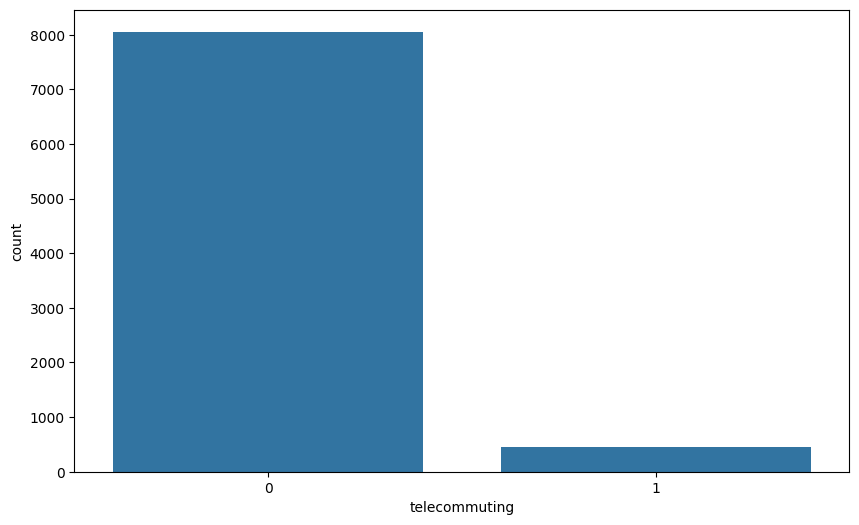

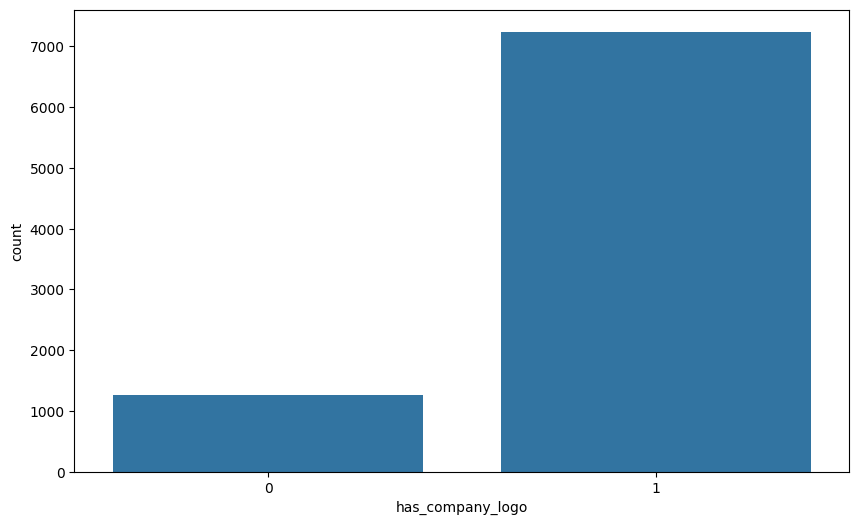

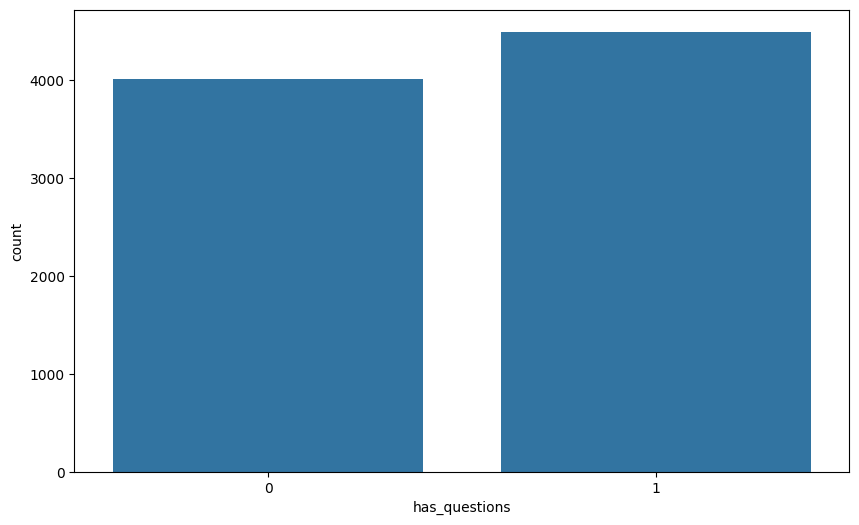

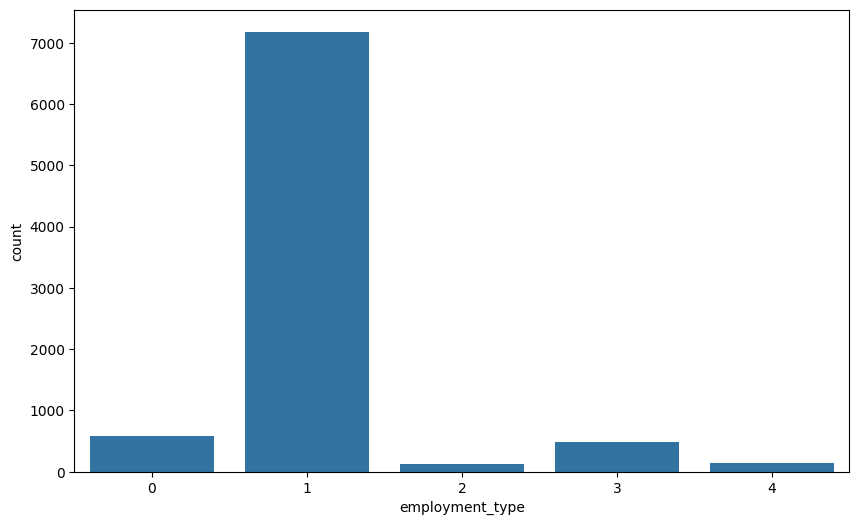

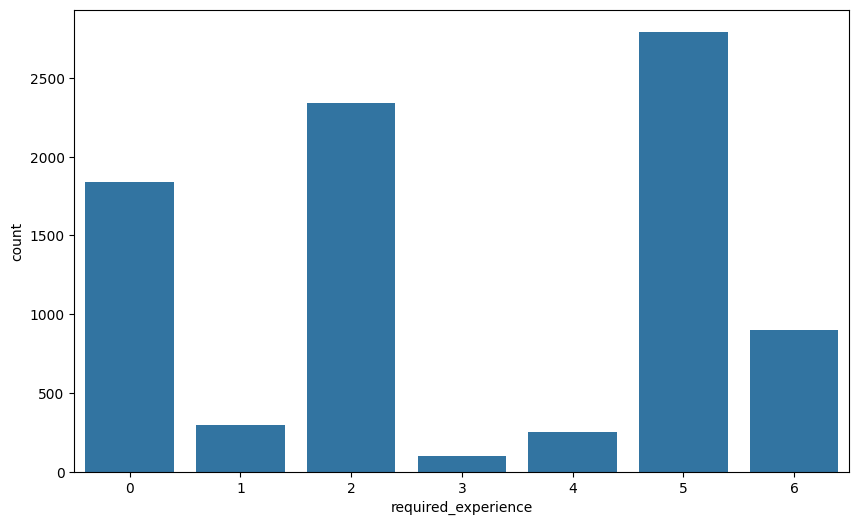

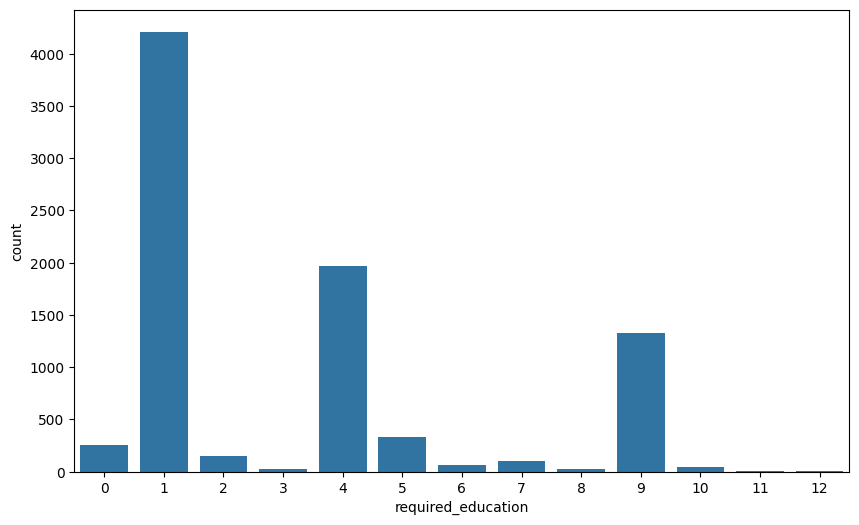

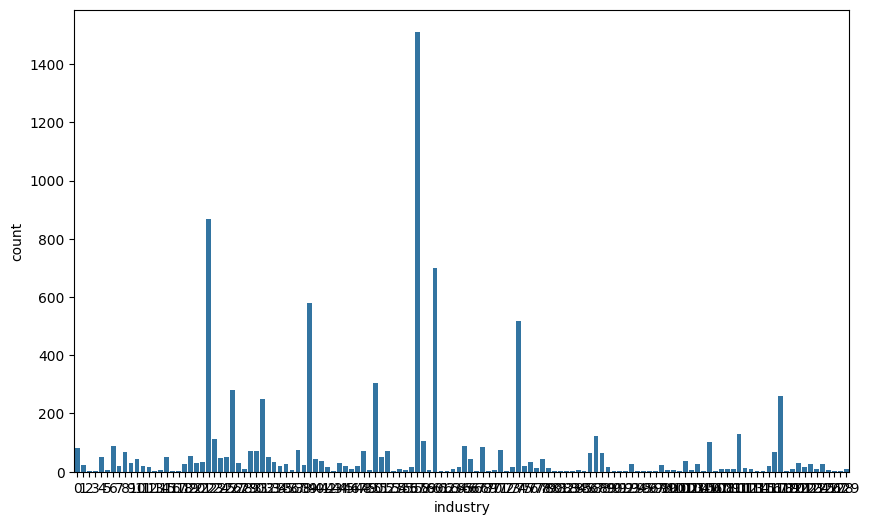

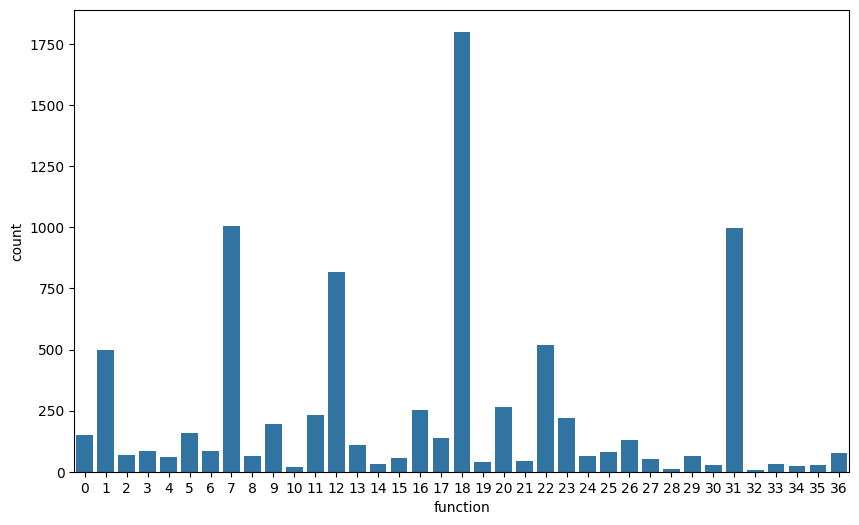

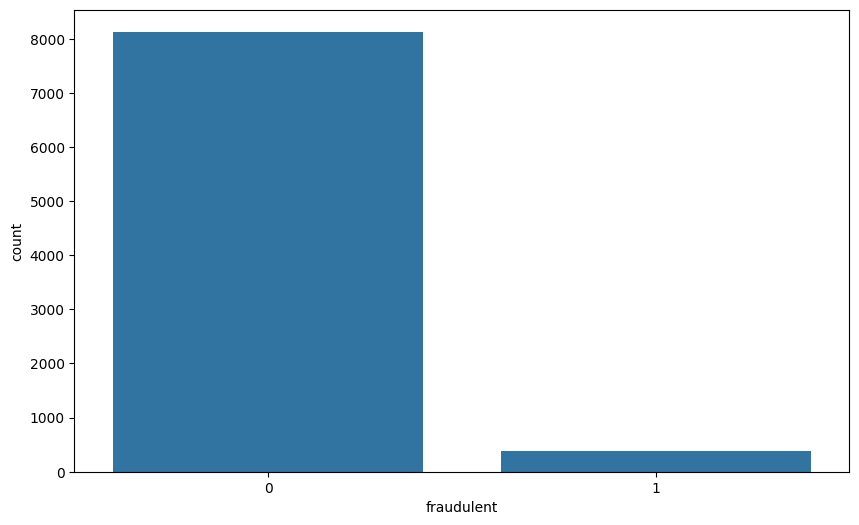

In [15]:
for i in data.columns:
  plt.figure(figsize=(10, 6))
  sns.countplot(x=i,data = data)

На последней гистограмме можем наблюдать несбалансированность классов

**Построение корреляционной матрицы**

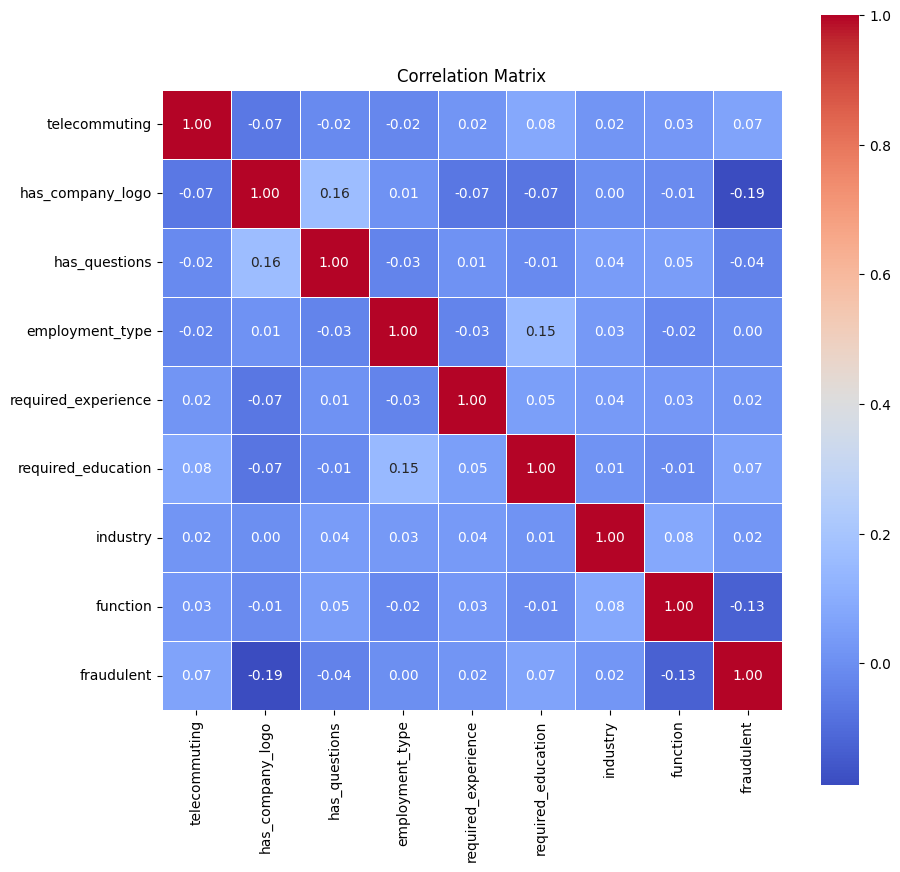

In [16]:
corr_matrix = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Удаление признаков, которые сильно кореллируют между собой**

Признаки коррелируют между собой слабо, что говорит о высокой степени их независимости. Поэтому удалять признаки нет смысла

**Нормализация признаков датасета**

In [17]:
for i in range(0, len(numeric_sign_name)):
  data[numeric_sign_name[i]] = (data[numeric_sign_name[i]] - data[numeric_sign_name[i]].min()) / (data[numeric_sign_name[i]].max() - data[numeric_sign_name[i]].min())
for i in range(0, len(category_sign_name)):
  data[category_sign_name[i]] = (data[category_sign_name[i]] - data[category_sign_name[i]].min()) / (data[category_sign_name[i]].max() - data[category_sign_name[i]].min())

Выведем результаты на экран:

In [18]:
data.describe()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000,8511.000000
mean,0.053460,0.851016,0.528258,0.277406,0.501743,0.273528,0.411717,0.448126,0.044648
std,0.224963,0.356093,0.499230,0.167030,0.359264,0.248015,0.223778,0.252977,0.206542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.250000,0.166667,0.083333,0.224806,0.222222,0.000000
50%,0.000000,1.000000,1.000000,0.250000,0.333333,0.083333,0.441860,0.500000,0.000000
75%,0.000000,1.000000,1.000000,0.250000,0.833333,0.333333,0.503876,0.611111,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Разделение данных на обучающую и тестовую выборки**

In [19]:
X = data.drop('fraudulent', axis=1)
y = data['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размер обучающей выборки: ", X_train.shape[0])
print("Размер тестовой выборки: ", X_test.shape[0])

Размер обучающей выборки:  6808
Размер тестовой выборки:  1703


**Запуск алгоритм KNN (k ближайший соседей)**

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred2 = knn.predict(X_train)
accuracy2 = accuracy_score(y_train, y_pred2)
print('Точность train: ', accuracy2)
print('Точность test: ', accuracy)

Точность train:  0.9728260869565217
Точность test:  0.9647680563711099


**Подбор оптимального параметра k**

Алгоритм работает и выдает неплохой результат. Попробуем улучшить результат:

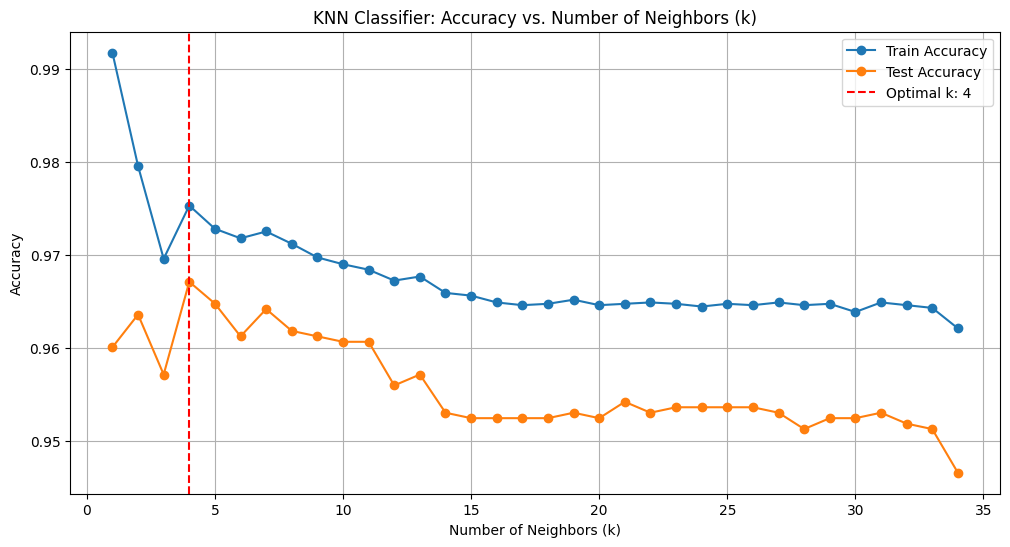

Оптимальное количество соседей:  4
Лучшая точность на тренировочной выборке:  0.9917743830787309
Лучшая точность на тестовой выборке:  0.9671168526130358


In [21]:
train_accuracies = []
test_accuracies = []
for k in range(1, 35):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

optimal_k = test_accuracies.index(max(test_accuracies)) + 1  # +1 для получения значения k

plt.figure(figsize=(12, 6))
plt.plot(range(1, 35), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 35), test_accuracies, label='Test Accuracy', marker='o')
plt.axvline(optimal_k, linestyle='--', color='red', label=f'Optimal k: {optimal_k}')
plt.title('KNN Classifier: Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

best_train_accuracy = max(train_accuracies)
best_test_accuracy = max(test_accuracies)
print("Оптимальное количество соседей: ", optimal_k)
print("Лучшая точность на тренировочной выборке: ", best_train_accuracy)
print("Лучшая точность на тестовой выборке: ", best_test_accuracy)

**Алгоритм Random Forest**

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred2 = rf_classifier.predict(X_train)
accuracy2 = accuracy_score(y_train, y_pred2)
print('Точность train: ', accuracy2)
print('Точность test: ', accuracy)

Точность train:  0.9926556991774383
Точность test:  0.9729888432178508


**Подбор оптимального значения параметра n_estimators**

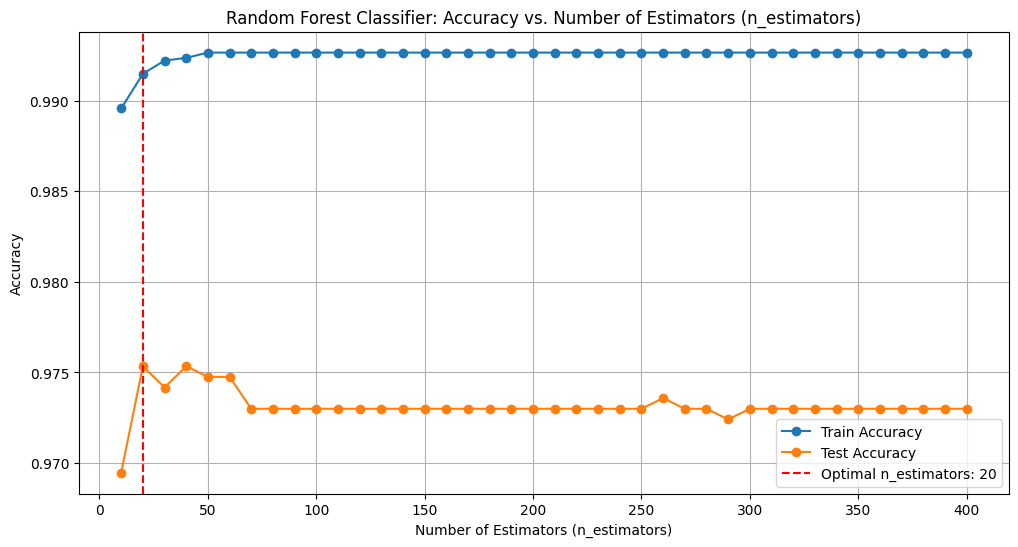

Оптимальное количество деревьев:  20
Лучшая точность на тренировочной выборке:  0.9926556991774383
Лучшая точность на тестовой выборке:  0.9753376394597769


In [23]:
train_accuracies = []
test_accuracies = []
for n_estimators in range(10, 401, 10):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)
    y_train_pred = rf_classifier.predict(X_train)
    y_test_pred = rf_classifier.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Поиск оптимального значения n_estimators по максимальной точности на тестовой выборке
optimal_n_estimators = (test_accuracies.index(max(test_accuracies)) + 1) * 10  # +1 и *10 для получения значения n_estimators

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(range(10, 401, 10), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(10, 401, 10), test_accuracies, label='Test Accuracy', marker='o')
plt.axvline(optimal_n_estimators, linestyle='--', color='red', label=f'Optimal n_estimators: {optimal_n_estimators}')
plt.title('Random Forest Classifier: Accuracy vs. Number of Estimators (n_estimators)')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

best_train_accuracy = max(train_accuracies)
best_test_accuracy = max(test_accuracies)
print("Оптимальное количество деревьев: ", optimal_n_estimators)
print("Лучшая точность на тренировочной выборке: ", best_train_accuracy)
print("Лучшая точность на тестовой выборке: ", best_test_accuracy)

В целом результаты лучше, чем у алгоритма KNN.

**Борьба с несбалансированностью классов**

Несбалансированность классов существенна (5/95), необходимо ее побороть. Можно уменьшить число объектов в большем по размеру классе, но это уменьшит выборку и негативно скажется на обучении. Можно увеличить число примеров меньшего по размеру класса. Один из популярных методов — SMOTE (Synthetic Minority Over-sampling Technique), который создает синтетические примеры на основе существующих, напрямую не копируя их.

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

data_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Все 9 признаков
data_resampled['fraudulent'] = y_resampled  # Добавление целевой переменной

Проверим размерность:

In [25]:
print(data_resampled.shape)

(13046, 9)


Убедимся в сбалансированности:

<ipython-input-26-9d6a7ec9496e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=data_resampled, palette='pastel')


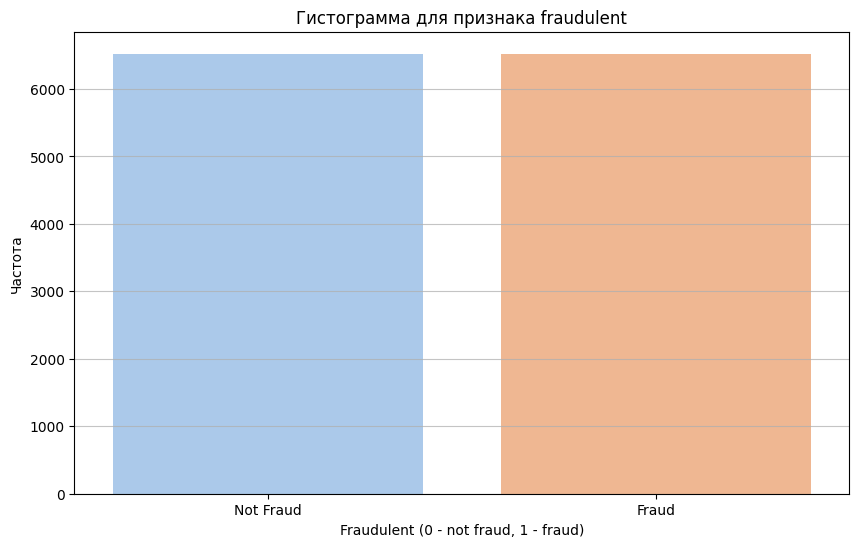

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fraudulent', data=data_resampled, palette='pastel')
plt.title('Гистограмма для признака fraudulent')
plt.xlabel('Fraudulent (0 - not fraud, 1 - fraud)')
plt.ylabel('Частота')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])  # Подписи для оси X
plt.grid(axis='y', alpha=0.75)
plt.show()

Разобьем новый датасет на обучающую и тестовую выборки:

In [27]:
X_train_resampled, X_test_resampled, Y_train_resampled, Y_test_resampled = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

Заново запустим алгоритм KNN:

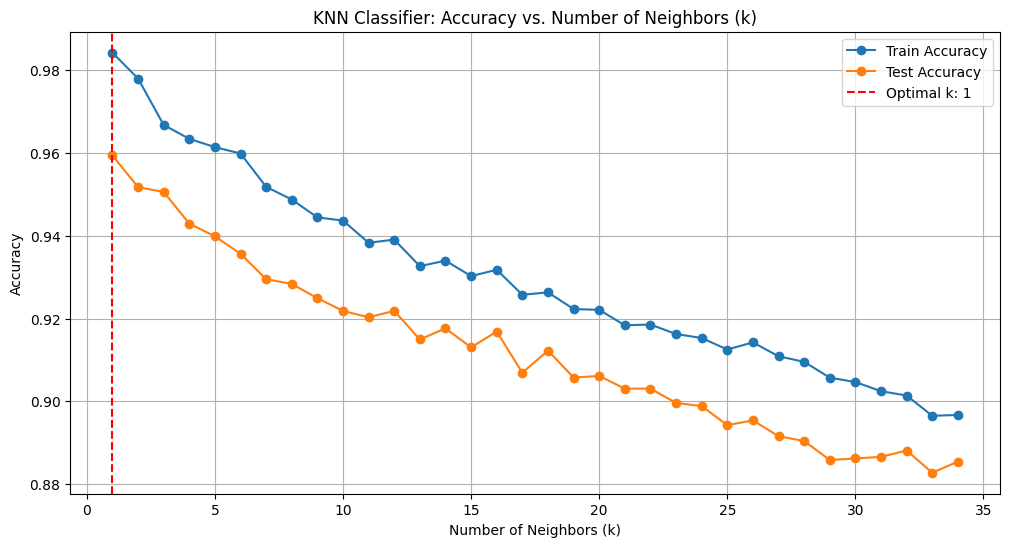

Оптимальное количество соседей:  1
Лучшая точность на тренировочной выборке:  0.9841893445764661
Лучшая точность на тестовой выборке:  0.9593869731800766


In [28]:
train_accuracies = []
test_accuracies = []
for k in range(1, 35):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_resampled, Y_train_resampled)
    y_train_pred = knn.predict(X_train_resampled)
    y_test_pred = knn.predict(X_test_resampled)
    train_accuracy = accuracy_score(Y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(Y_test_resampled, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

optimal_k = test_accuracies.index(max(test_accuracies)) + 1  # +1 для получения значения k

plt.figure(figsize=(12, 6))
plt.plot(range(1, 35), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 35), test_accuracies, label='Test Accuracy', marker='o')
plt.axvline(optimal_k, linestyle='--', color='red', label=f'Optimal k: {optimal_k}')
plt.title('KNN Classifier: Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

best_train_accuracy = max(train_accuracies)
best_test_accuracy = max(test_accuracies)
print("Оптимальное количество соседей: ", optimal_k)
print("Лучшая точность на тренировочной выборке: ", best_train_accuracy)
print("Лучшая точность на тестовой выборке: ", best_test_accuracy)

Заново запустим Random Forest:

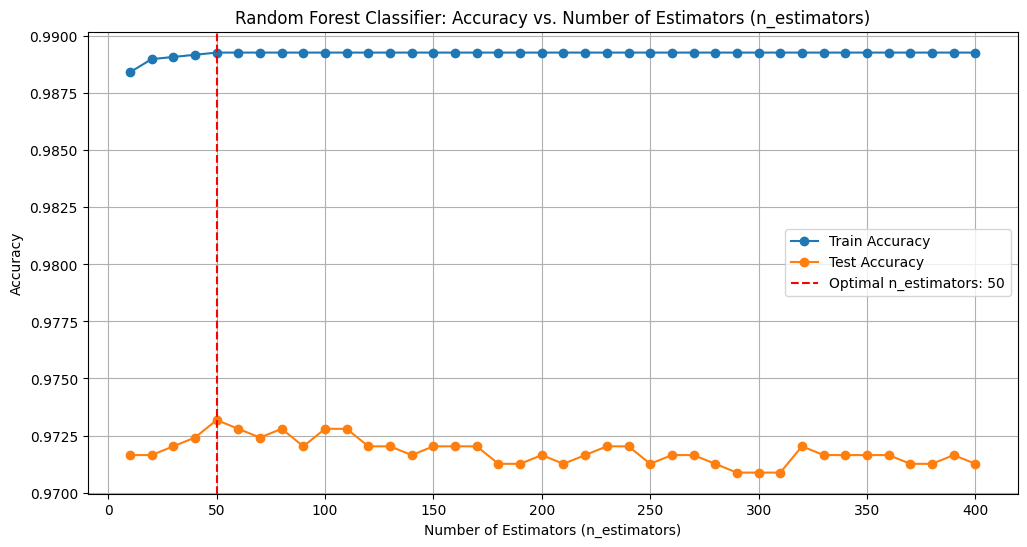

Оптимальное количество деревьев:  50
Лучшая точность на тренировочной выборке:  0.9892679187428134
Лучшая точность на тестовой выборке:  0.9731800766283525


In [29]:
train_accuracies = []
test_accuracies = []
for n_estimators in range(10, 401, 10):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train_resampled, Y_train_resampled)
    y_train_pred = rf_classifier.predict(X_train_resampled)
    y_test_pred = rf_classifier.predict(X_test_resampled)
    train_accuracy = accuracy_score(Y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(Y_test_resampled, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Поиск оптимального значения n_estimators по максимальной точности на тестовой выборке
optimal_n_estimators = (test_accuracies.index(max(test_accuracies)) + 1) * 10  # +1 и *10 для получения значения n_estimators

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(range(10, 401, 10), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(10, 401, 10), test_accuracies, label='Test Accuracy', marker='o')
plt.axvline(optimal_n_estimators, linestyle='--', color='red', label=f'Optimal n_estimators: {optimal_n_estimators}')
plt.title('Random Forest Classifier: Accuracy vs. Number of Estimators (n_estimators)')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

best_train_accuracy = max(train_accuracies)
best_test_accuracy = max(test_accuracies)
print("Оптимальное количество деревьев: ", optimal_n_estimators)
print("Лучшая точность на тренировочной выборке: ", best_train_accuracy)
print("Лучшая точность на тестовой выборке: ", best_test_accuracy)

# **Вывод**

Была рассмотрена задача бинарной классификации. Исходные данные содержали 17880 записей, которые были визуализированы и предобработаны. При использовании алгоритма K-ближайших соседей точность на тестовой выборке составила  0.9671168526130358, а для алгоритма Random Forest точность на тестовой выборке составила 0.9753376394597769. Казалось бы, это высокая точность, но учитывая несбалансированность классов (5/95), этого не достаточно. Необходимо убрать несбалансированность классов.
Несбалансированность классов была убрана, для алгоритма K-ближайших соседей точность на тестовой выборке составила  0.9593869731800766, а для алгоритма Random Forest точность на тестовой выборке составила 0.9731800766283525. У алгоритма Random Forest результат несколько лучше. Учитывая сбалансированность классов у обработанного датасета, это хорошая точность.

Скачаем обработанный датасет:

In [30]:
data_resampled.to_csv('corrected_dataset.csv', index=False)